**CELL_1 - Loads required libraries, shows dataset folders, and sets basic training settings (image size, batch size, epochs, seed, validation split).**

In [1]:
# Cell 1: Import libraries and dataset setup

import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight

# Path to dataset 
DATA_DIR = "/kaggle/input/skin-cancer-malignant-vs-benign"

# Print directory structure
print("Main folder:", os.listdir(DATA_DIR))
print("Train subfolders:", os.listdir(os.path.join(DATA_DIR, "train")))
print("Test subfolders:", os.listdir(os.path.join(DATA_DIR, "test")))

# Hyperparameters
IMG_SIZE = (224, 224)   # resize images
BATCH_SIZE = 32
EPOCHS = 10             # start small, can increase later
SEED = 42
VAL_SPLIT = 0.2

2025-08-19 14:27:03.583113: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755613623.830494      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755613623.905202      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Main folder: ['data', 'test', 'train']
Train subfolders: ['benign', 'malignant']
Test subfolders: ['benign', 'malignant']


**CELL_2 - Defines where the dataset is stored and sets training rules like image size, batch size, epochs, and validation split.**

In [2]:
# Cell 2: dataset path and training settings

DATA_DIR = "./skin_cancer_data"   # dataset folder
IMG_SIZE = (224, 224)             # resize images
BATCH_SIZE = 32                   # images per batch
SEED = 42                         # for reproducibility
EPOCHS = 20                       # training rounds
VAL_SPLIT = 0.20                  # part of data for validation

**CELL_3 - Prints the dataset folder structure to confirm files and subfolders are present.**

In [3]:
# Cell 3: check dataset structure

for root, dirs, files in os.walk(DATA_DIR):
    print("Folder:", root)
    print("Subfolders:", dirs)
    break

**CELL_4 - This cell loads the training images, applies data augmentation (like rotation, zoom, flip), splits them into training and validation sets, rescales pixels, and shows how many samples and classes are there.**

In [4]:
# Cell 4 Correct dataset paths
TRAIN_DIR = "/kaggle/input/skin-cancer-malignant-vs-benign/train"
TEST_DIR  = "/kaggle/input/skin-cancer-malignant-vs-benign/test"

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    horizontal_flip=True,
    validation_split=0.2
)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True,
    seed=SEED
)

val_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False,
    seed=SEED
)

print("Train samples:", train_gen.samples)
print("Val samples:", val_gen.samples)
print("Classes:", train_gen.class_indices)


Found 2110 images belonging to 2 classes.
Found 527 images belonging to 2 classes.
Train samples: 2110
Val samples: 527
Classes: {'benign': 0, 'malignant': 1}


**CELL_5 - This cell calculates class weights to handle imbalance (if one class has more images than the other). These weights help the model treat both classes fairly during training.**

In [5]:
# Cell 5: Class weights
from sklearn.utils import class_weight

y_train = train_gen.classes
classes = np.unique(y_train)
cw = class_weight.compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weights = {i: float(cw_val) for i, cw_val in enumerate(cw)}
print("Class weights:", class_weights)

Class weights: {0: 0.9157986111111112, 1: 1.1012526096033404}



**CELL_6 - This cell builds a CNN model.It takes in images of size 224×224×3.Applies convolution + pooling layers to learn image features.Flattens features and passes them through dense layers.Uses a sigmoid output to classify as malignant (1) or benign (0).Compiles the model with Adam optimizer and binary crossentropy loss.This cell creates and prepares the main CNN model for training.**


In [6]:
# Cell 6: Build CNN model (clean version)
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Input(shape=(*IMG_SIZE, 3)),
    
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

2025-08-19 14:27:24.520061: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

**CELL_7 - builds a larger and stronger CNN model with multiple convolution layers (32, 64, 128, 256 filters), batch normalization for stability, and dropout to prevent overfitting. It is designed to better capture image features compared to the smaller model in Cell 6. The model is then trained for 5 epochs on the training data while also validating on the validation set, and class weights are applied to handle imbalance between benign and malignant samples.**

In [7]:
# Cell 7: Bigger CNN (no pretrained weights)

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential([
    Input(shape=(224, 224, 3)),

    Conv2D(32, (3,3), activation='relu', padding="same"),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Conv2D(64, (3,3), activation='relu', padding="same"),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Conv2D(128, (3,3), activation='relu', padding="same"),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Conv2D(256, (3,3), activation='relu', padding="same"),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,   # train 
    class_weight=class_weights,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 191s 3s/step - accuracy: 0.6982 - loss: 4.9514 - val_accuracy: 0.4535 - val_loss: 3.2317
Epoch 2/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 183s 3s/step - accuracy: 0.6900 - loss: 0.5431 - val_accuracy: 0.5465 - val_loss: 8.2905
Epoch 3/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 206s 3s/step - accuracy: 0.7127 - loss: 0.5218 - val_accuracy: 0.5465 - val_loss: 11.8554
Epoch 4/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 182s 3s/step - accuracy: 0.7437 - loss: 0.5096 - val_accuracy: 0.5465 - val_loss: 6.7891
Epoch 5/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 181s 3s/step - accuracy: 0.7730 - loss: 0.4781 - val_accuracy: 0.5882 - val_loss: 2.4048


**Cell 8 checks how well the model performs on the validation set by printing accuracy and loss, then plots graphs showing how training and validation accuracy/loss changed over the epochs. This helps to see if the model is learning well or overfitting.**

17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 852ms/step - accuracy: 0.7816 - loss: 1.0559
Validation Accuracy: 0.5939
Validation Loss: 2.4401


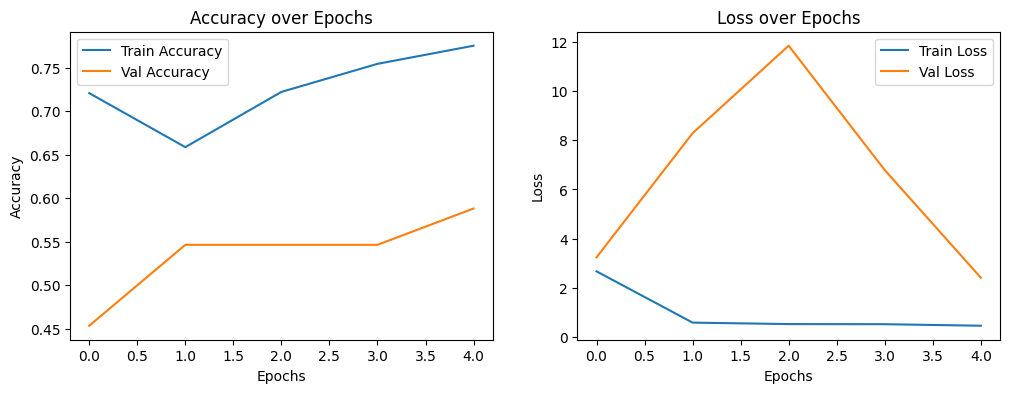

In [8]:
# Cell 8: Evaluate and visualize training

import matplotlib.pyplot as plt

# Evaluate on validation data
val_loss, val_acc = model.evaluate(val_gen, verbose=1)
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

# Plot training history
plt.figure(figsize=(12,4))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Val Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy over Epochs")

# Loss plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss over Epochs")

plt.show()

**Cell 9 uses the trained model to make predictions on the validation data, compares them with the true labels, and then shows a confusion matrix (to see correct vs wrong predictions for each class) along with a classification report (precision, recall, and F1-score for benign and malignant). This gives a detailed picture of how well the model is performing on each class.**

17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 863ms/step


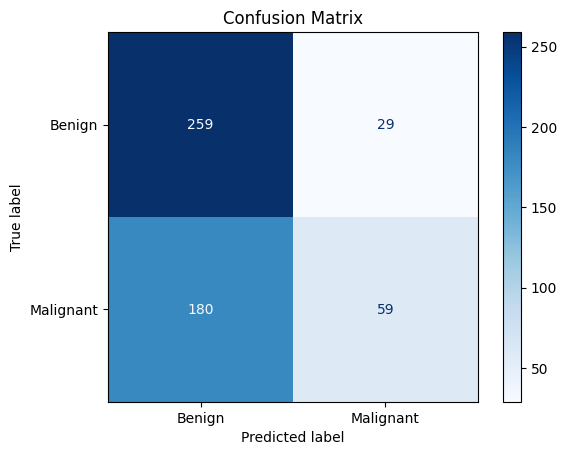

Classification Report:
              precision    recall  f1-score   support

      Benign       0.59      0.90      0.71       288
   Malignant       0.67      0.25      0.36       239

    accuracy                           0.60       527
   macro avg       0.63      0.57      0.54       527
weighted avg       0.63      0.60      0.55       527



In [9]:
# Cell 9: Predictions and Confusion Matrix
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Get true labels and predictions
y_true = val_gen.classes
y_pred = model.predict(val_gen, verbose=1)
y_pred = (y_pred > 0.5).astype(int).ravel()

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Malignant"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Detailed classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Benign", "Malignant"]))

**Cell 10 randomly picks some images from the validation set, shows them, and displays both the true label and the model’s predicted label. This helps visually check how well the model is identifying benign vs malignant cases.**

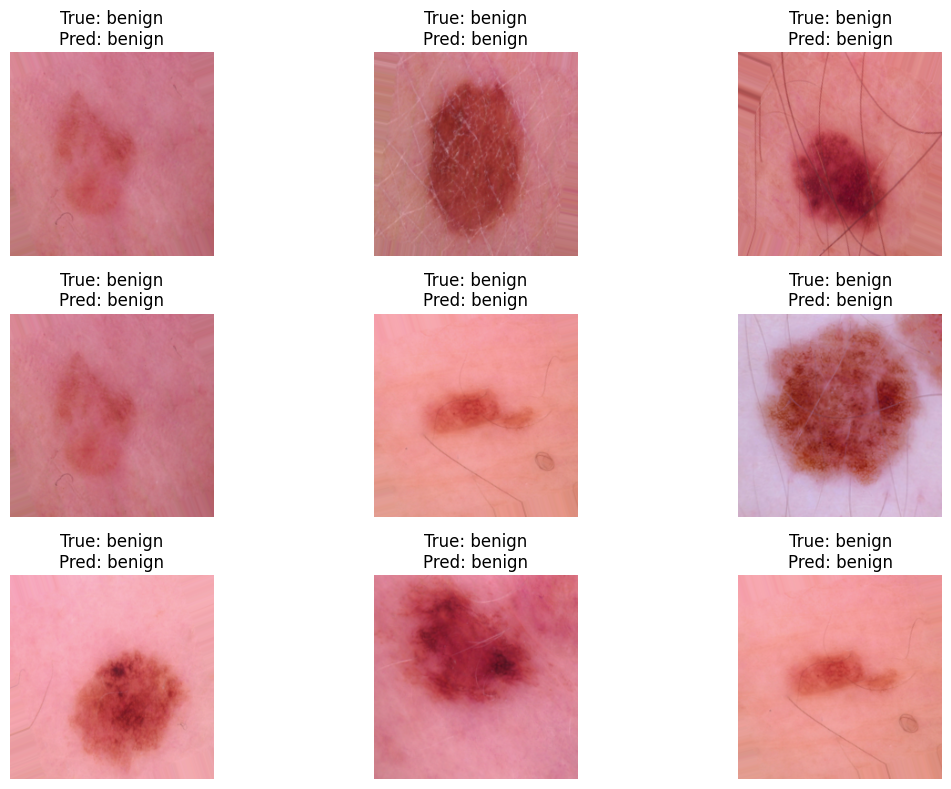

In [10]:
# Cell 10: Show sample predictions
import random

# Get class labels
class_labels = list(val_gen.class_indices.keys())

# Pick random images from validation set
x_val, y_val = next(val_gen)
plt.figure(figsize=(12, 8))

for i in range(9):  # show 9 images
    idx = random.randint(0, len(x_val)-1)
    img = x_val[idx]
    true_label = int(y_val[idx])
    
    # Predict
    pred_prob = model.predict(img[np.newaxis, ...], verbose=0)[0][0]
    pred_label = int(pred_prob > 0.5)
    
    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"True: {class_labels[true_label]}\nPred: {class_labels[pred_label]}")
    
plt.tight_layout()
plt.show()

**Cell 11 saves the trained model into a file called skin_cancer_model.h5, so you don’t need to retrain it every time and can directly load and use it later.**

In [11]:
# Cell 11: Save the trained model
model.save("skin_cancer_model.h5")

print("Model saved successfully as skin_cancer_model.h5")

Model saved successfully as skin_cancer_model.h5



**Cell 12 checks how well the model is performing. It makes predictions on the validation data, compares them with the true labels, and then shows two results:A classification report with accuracy, precision, recall, and F1-score for each class (benign and malignant).A confusion matrix that shows how many predictions were correct and where the model made mistakes.This helps to clearly understand the model’s strengths and weaknesses.**


In [12]:
# Cell 12: Model evaluation with classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Get predictions
y_pred = model.predict(val_gen)
y_pred_classes = (y_pred > 0.5).astype("int32")

# True labels
y_true = val_gen.classes

# Classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=val_gen.class_indices.keys()))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
print("\nConfusion Matrix:\n", cm)

17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 860ms/step
Classification Report:

              precision    recall  f1-score   support

      benign       0.59      0.90      0.71       288
   malignant       0.67      0.26      0.37       239

    accuracy                           0.61       527
   macro avg       0.63      0.58      0.54       527
weighted avg       0.63      0.61      0.56       527


Confusion Matrix:
 [[258  30]
 [178  61]]
